### Question 2

#### Q2 (a) Solve this problem using any method that we have learned (value function iteration, policy function iteration, grid searches, interpolation, etc...).5 You will need to determine how many grid points are necessary, and determine appropriate bounds on the asset grid.6 Discuss the choices you made, and defend why you made them. Plot the relevant policy functions in a sensible way, and discuss the results. In particular, you should plot consumption as a share of available resources. What stands out to you? 

We chose to employ the VFI approach because we felt it is the simplest. We are implementing this in Python because our Julia code kept getting stuck in loops (we spent maybe 10 hours trying to figure it out before we swtiched). 

In [1]:
## Importing Packages 

import quantecon as qe 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Setting up the parameters

beta, r, mu, rho, var, sigma = 0.95, 0.04, 0.5, 0.8, 0.1, 2
parameters = [beta, r, mu, rho, var, sigma]

Below we define all the functions that we will need to solve the problem. First, we define the utility function. We then proceed to the update Bellman. Finally, we create the solve function

In [3]:
def u(c):
    utility = (c**(1-sigma)) / (1-sigma) 
    return np.where(c>0, utility, float("-inf"))

In [4]:
def bellman(parameters, V, policy, optimal_consumption, asset_grid, income_grid, expected_value):
    for i in range(len(asset_grid)):
        a = asset_grid[i] 
        for j in range((len(income_grid))):
            Y = np.exp(income_grid[j]) 
            z = (1 + r) * a + (Y) 
            c = z - asset_grid 

            potential_utils = u(c) + beta * expected_value[:, j] 
                    
            V[i, j] = np.max(potential_utils) 
            location = np.argmax(potential_utils) 
            policy[i, j] = asset_grid[location]
            consumption = (1+r)*a + Y - asset_grid[location] 
            optimal_consumption[i,j] = consumption
    return 

In [5]:
def solve(parameters, asset_grid, V0, inc_pts, tolerance = 1e-12, maxiter = 1000):
    beta, r, mu, rho, var, sigma = parameters 
    V0                           = np.copy(V0)
    V                            = np.copy(V0)
    errors                       = []  
    iteration_count              = 0

    # Discretizing the income process
    mc            = qe.markov.approximation.rouwenhorst(n = inc_pts,rho = 0.8, sigma=0.1, mu = 0.5) 
    P             = np.transpose(mc.P) 
    income_grid   = mc.state_values 
    
    #Initialising guesses
    V                   = np.zeros((len(asset_grid), len(income_grid))) 
    policy              = np.zeros((len(asset_grid), len(income_grid))) 
    optimal_consumption = np.zeros((len(asset_grid), len(income_grid)))
    
    # Run until error convergence
    while True: 
        iteration_count += 1 
        
        expected_value = np.matmul(V0,P)

        bellman(parameters, V, policy, optimal_consumption, asset_grid, income_grid, expected_value)

        error = np.max(np.abs(V - V0))
        
        errors.append(error)
        
        if error < tolerance:
            break 
        V0 = V.copy()

    return (V, policy, optimal_consumption, iteration_count, errors, asset_grid, income_grid)

In [6]:
inc_pts                 = 30
asset_pts               = 500
V0                      = np.zeros((asset_pts,inc_pts))
asset_grid              = np.linspace(1e-6, 500, asset_pts)  
result                  = solve(parameters, asset_grid, V0,inc_pts, tolerance = 1e-3, maxiter = 1000)

/var/folders/tb/tb7zlgfn0ngdmf43v0_x7vsc0000gn/T/ipykernel_53802/4130054340.py:9: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc            = qe.markov.approximation.rouwenhorst(n = inc_pts,rho = 0.8, sigma=0.1, mu = 0.5)


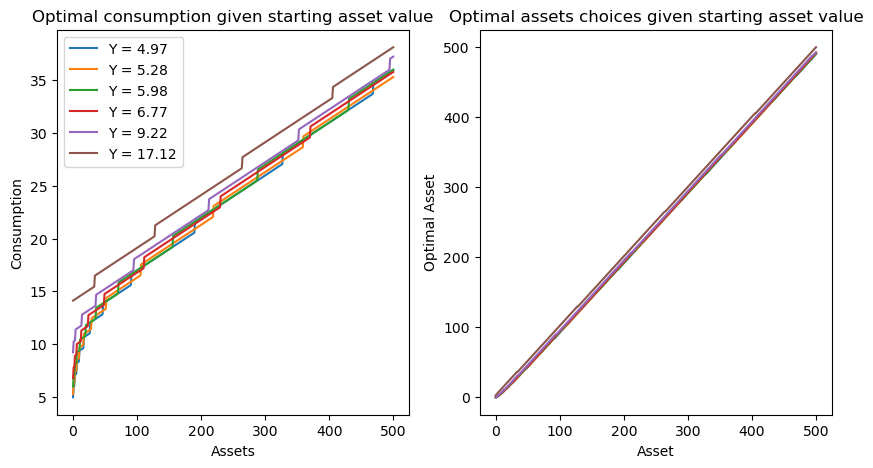

In [7]:
optimal_asset       = result[1] 
optimal_consumption = result[2]
income_grid         = result[6] 
Y                   = [0, 1, 3, 5, 10, 20]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in Y:
    label = f'Y = {np.exp(income_grid[i]):.2f}'  
    ax[0].plot(asset_grid, optimal_consumption[:, i], label=label)
    ax[0].set_ylabel('Consumption')
    ax[0].set_xlabel('Assets')
    ax[0].set_title('Optimal consumption given starting asset value')

ax[0].legend()

for i in Y:
    label = f'Y = {np.exp(income_grid[i]):.2f}'  
    ax[1].plot(asset_grid, optimal_asset[:, i], label=label)
    ax[1].set_ylabel('Optimal Asset')
    ax[1].set_xlabel('Asset')
    ax[1].set_title('Optimal assets choices given starting asset value')

plt.show()

We have two observations:

1. For the left panel, we see a relatively logarithmic relationship between assets and consumption. The greatest increase in consumption comes from the marginal asset incremenets when assets < 100. After that point, there seems to be a relatively linear increase. A distant illustration of this could be a person consuming a lot more shortly after they become moderately wealthy, but the marginal increase declines as they become very wealthy (Chodrow-Reich, 2019). We believe this would also imply that consumption should fall as a share of wealth (i.e. consumption/assets would look like an exponentially decaying function). Despite this, we would still expect people consume a similar share of their income regardless of how large their income is. This is because of how closely clustered the consumption paths are. 

 

2. For the right panel, we see that the optimal asset value is a linear function of asset values. This would mean that individuals consume their income and asset returns in period $t$ and maintain their intial ednowment in $t+1$.

#### 2b - 5 workers

In [9]:
V, policy, optimal_consumption, iteration_count, errors, asset_grid, income_grid = result

# Containers for tracking across individuals
Asset_store, Cons_store, Y_store = [], [], []

# Initial conditions for simulation
initial_asset_index = 200  
initial_income_index = 20  

# Simulate for 5 individuals
for _ in range(5): 
 
    a_temp, c_temp, y_temp = [], [], []
    
    # Initial setup for each individual
    current_asset_index = initial_asset_index
    current_income_index = initial_income_index
    next_asset_index = int(policy[current_asset_index, current_income_index])
    
    # Iterate over 100 periods for each individual
    for period in range(100):
        # Randomly select a new income index for each period
        new_income_index = np.random.randint(0, 29)  # Assuming 29 as an inclusive upper limit
        
        # Update bins
        y_temp.append(np.exp(income_grid[new_income_index]))
        
        # Calculate consumption based on policy and random income
        consumption = (1 + r) * asset_grid[current_asset_index] + np.exp(income_grid[new_income_index]) - asset_grid[next_asset_index]
        c_temp.append(consumption)
        
        # Update asset indexes for next period
        current_asset_index = next_asset_index
        next_asset_index = int(policy[next_asset_index, new_income_index])
        a_temp.append(next_asset_index)
    
    # Store individual's journey in overall bins
    Asset_store.append(a_temp)
    Cons_store.append(c_temp)
    Y_store.append(y_temp)


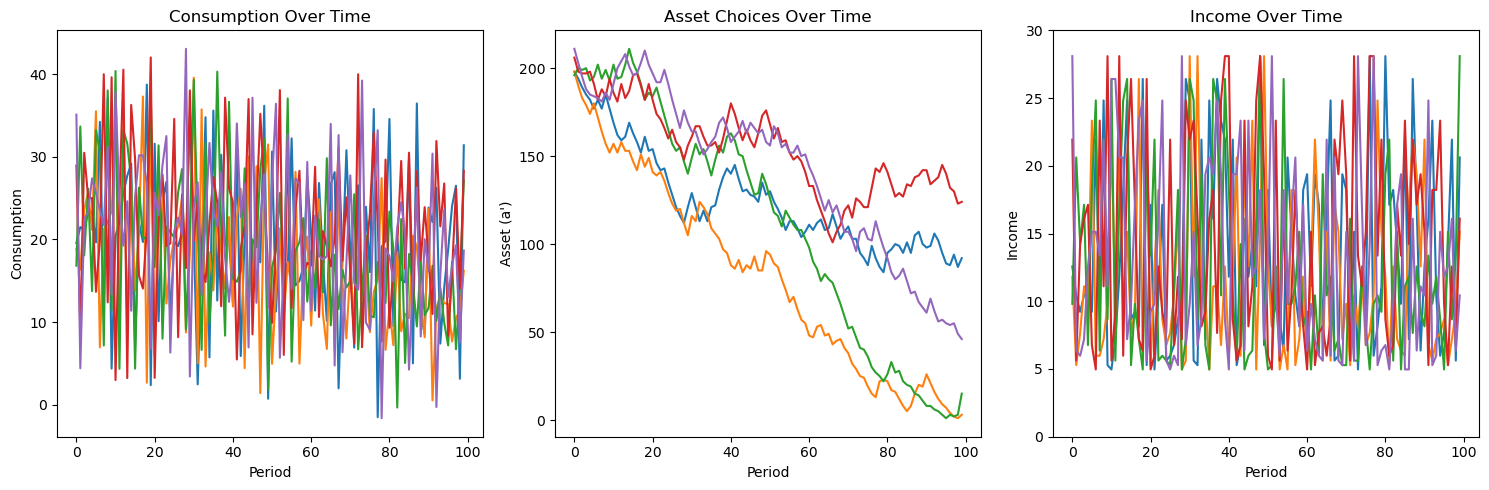

In [10]:
# Set up a figure with three subplots for Consumption, Asset ('a prime'), and Income
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Combine plotting into one loop for efficiency and clarity
for i in range(5):
    periods = range(100)  # Define the time periods once for all plots

    # Plot Consumption
    axes[0].plot(periods, Cons_store[i], label=f'Individual {i+1}')
    axes[0].set_title('Consumption Over Time')
    axes[0].set_xlabel('Period')
    axes[0].set_ylabel('Consumption')

    # Plot Asset ('a prime')
    axes[1].plot(periods, Asset_store[i], label=f'Individual {i+1}')
    axes[1].set_title('Asset Choices Over Time')
    axes[1].set_xlabel('Period')
    axes[1].set_ylabel('Asset (a\')')

    # Plot Income
    axes[2].plot(periods, Y_store[i], label=f'Individual {i+1}')
    axes[2].set_title('Income Over Time')
    axes[2].set_xlabel('Period')
    axes[2].set_ylabel('Income')

axes[2].set_ylim(0, 30)  # Setting Income plot's Y-axis limit

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

For consumption and income we observe extreme oscillating behaviour, with consumption possibly exceeding income (i.e. the range of the y-axis is greater). We find evidence for consumption exceeding income in the decline of assets over time. There is a clear downward trend, which would reflect that consumers subsidise their excessive consumption by consuming their assets.

#### 2c - 10,000 workers

In [26]:

initial_asset_index = next_asset_index 



def run_simulation(n_periods, n_simulations=10000):
    simulation_results = []
    for _ in range(n_simulations):
        current_asset_index = initial_asset_index  # Reset at the start of each simulation
        for _ in range(n_periods):
            y_rand = np.random.randint(0, 29)
            current_asset_index = int(policy[current_asset_index, y_rand])  # Update the asset index for the next period
        final_asset = asset_grid[current_asset_index]  # Get the final asset value
        simulation_results.append(final_asset)
    return simulation_results

# Run simulations
periods_100 = run_simulation(100)
periods_200 = run_simulation(200)
periods_300 = run_simulation(300)


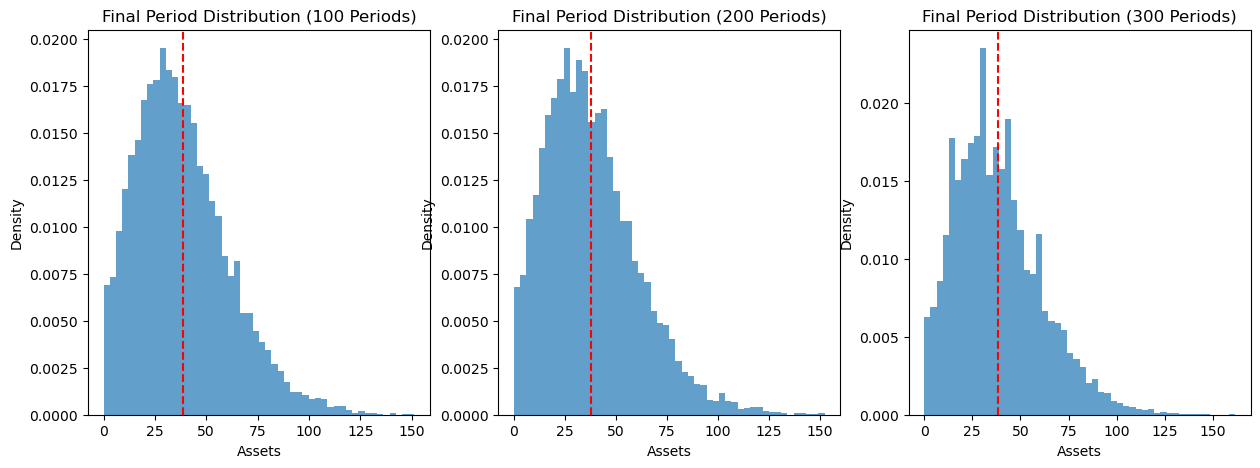

In [28]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].hist(periods_100, density=True, bins=50, alpha = 0.7)
ax[0].axvline(np.mean(periods_100), color = 'r', linestyle = 'dashed')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Assets')
ax[0].set_title('Final Period Distribution (100 Periods)')

ax[1].hist(periods_200, density=True, bins=50, alpha = 0.7)
ax[1].axvline(np.mean(periods_200), color = 'r', linestyle = 'dashed')
ax[1].set_ylabel('Density')
ax[1].set_xlabel('Assets')
ax[1].set_title('Final Period Distribution (200 Periods)')

ax[2].hist(periods_300, density=True, bins=50, alpha = 0.7)
ax[2].axvline(np.mean(periods_300), color = 'r', linestyle = 'dashed')
ax[2].set_ylabel('Density')
ax[2].set_xlabel('Assets')
ax[2].set_title('Final Period Distribution (300 Periods)')
plt.show()

The distributions are very similar even as we incremement the number of periods by 100. As foreshadowed above, consumers might find a "sweet spot" level of assets, which allows them to sustain their consumption patterns. It might be the case that our 5 workers were just "heavy consumers" (i.e. those with near 0 assets).